In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [29]:
df = pd.read_csv('../FormattedData/FDX_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [91]:
# This function removes highly correlated variables within the dataset. The function looks at the 
# Pearson Correlation Coefficient between every pair of variables in the dataset and returns all 
# of those between .8 and .999. While working with data from different companies, I found that by
# removing the first 90% of correlated variables within the DataFrame, in almost all cases, there
# were no longer correlations within the dataset.

In [92]:
# This function preprocesses my data so it is ready for distanced based regressions.

def preprocess_data(df, target_var = 'close'):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df[target_var].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)

    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [93]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [94]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [95]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()
y_hat_test = svr.predict(X_test_scaled)
print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9956835350948468
Train RMSE : 2.6054517640869403
Mean Train Cross-Validation Score: 0.9317092357902478


Text(0.5, 1.0, 'Test Residuals as a Percentage of Closing Price')

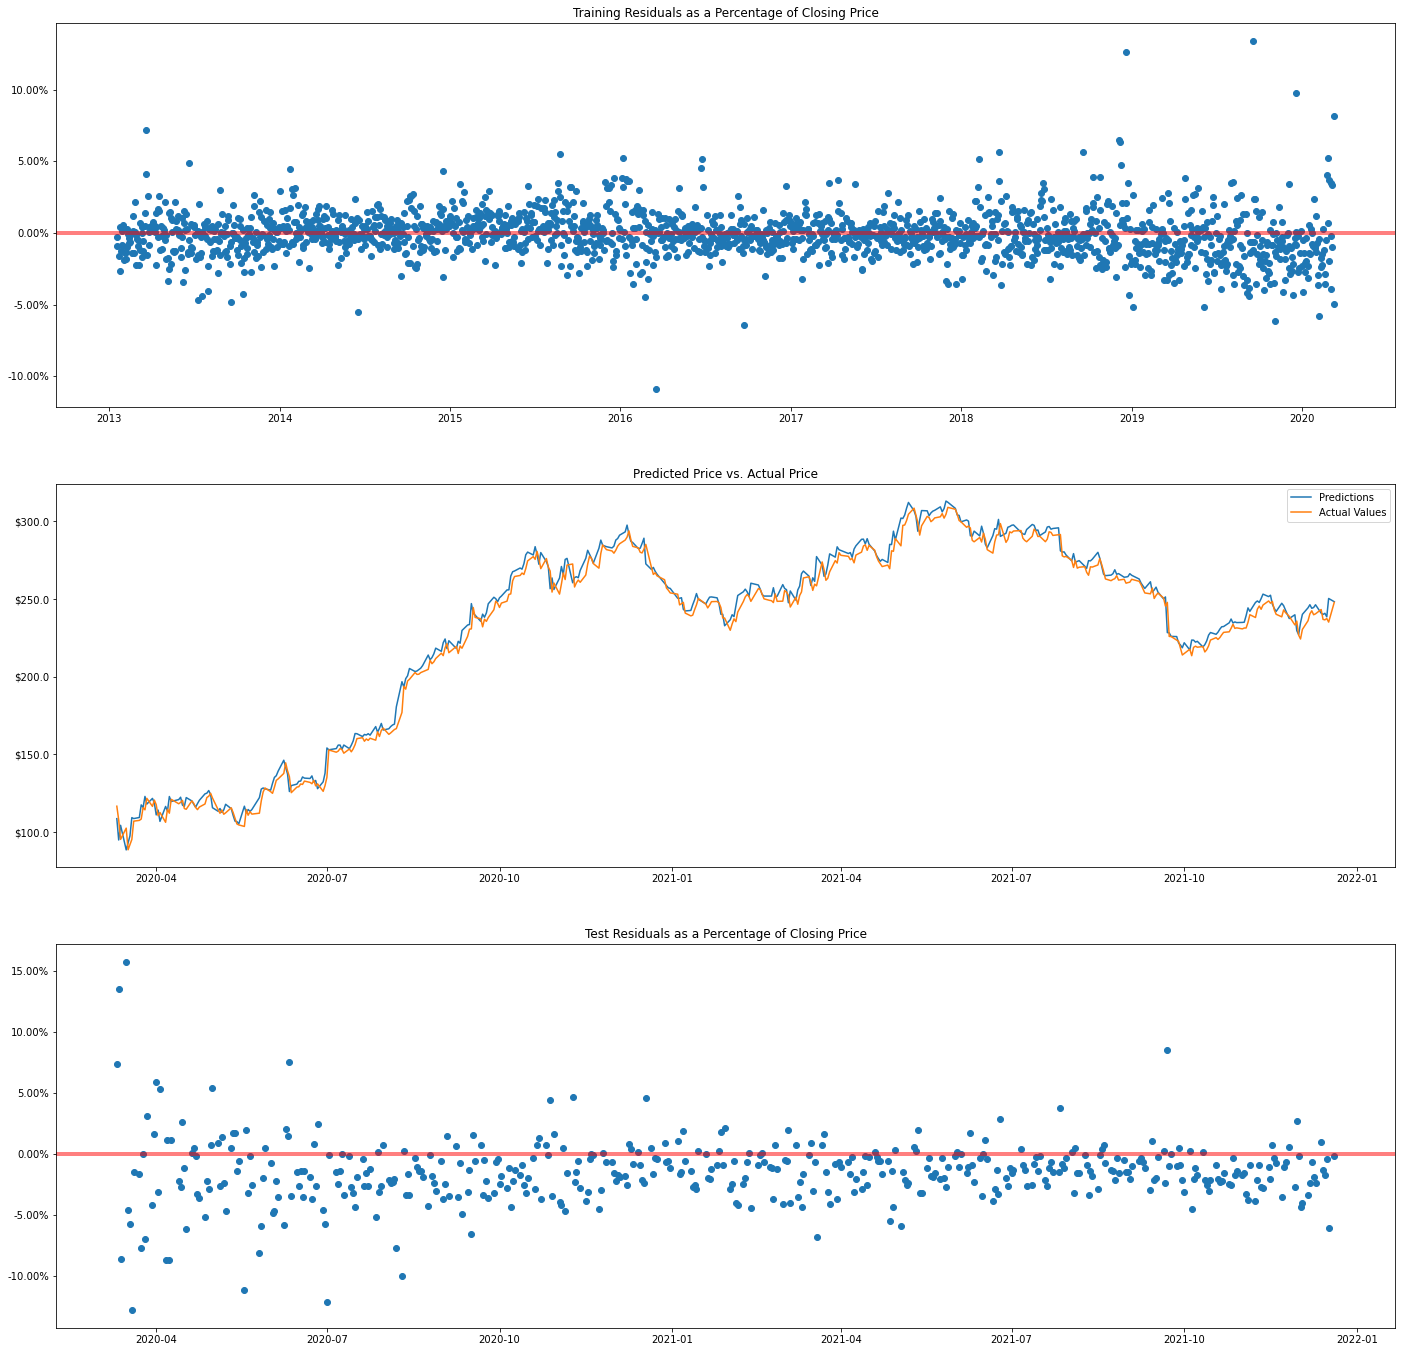

In [96]:
fig, ax = plt.subplots(3, figsize = (24,24))
ax0_x = y_train.index
ax0_y = (y_hat_train - y_train)/y_train
ax[0].scatter(ax0_x,ax0_y)
ax[0].yaxis.set_major_formatter('{x:1,.2%}')
ax[0].axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0)
ax[0].set_title('Training Residuals as a Percentage of Closing Price')

ax1_x = y_test.index 
ax1_y1 = preds_test.adjustedclose
ax1_y2 = y_hat_test
ax[1].plot(ax2_x, ax2_y1)
ax[1].plot(ax2_x, ax2_y2)
ax[1].set_title('Predicted Price vs. Actual Price')
ax[1].legend(['Predictions', 'Actual Values'])
ax[1].yaxis.set_major_formatter('${x}')

ax2_x = y_test.index
ax2_y = (y_hat_test - y_test)/y_test
ax[2].scatter(ax1_x,ax1_y)
ax[2].yaxis.set_major_formatter('{x:1,.2%}')
ax[2].axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0)
ax[2].set_title('Test Residuals as a Percentage of Closing Price')